In [1]:
import pandas as pd
import numpy as np

In [2]:
WDWweather = pd.read_excel('WDW Weather.xlsx')
DLRweather = pd.read_excel('DLR Weather.xlsx')
WDWincident = pd.read_excel('DLR IAAPA Incident ONLY 1_3.xlsx')
DLRincident = pd.read_excel('DLR IAAPA Incident ONLY 1_3.xlsx')

In [3]:
wdw_weather = DLRweather
wdw_incident = DLRincident

In [4]:
wdw_weather["Date"] = pd.to_datetime(wdw_weather["Date"])
wdw_incident["Date of Incident/Loss"] = pd.to_datetime(wdw_incident["Date of Incident/Loss"])

In [5]:
start_date = "2022-10-1"
end_date = "2024-09-15"

wdw_weather = wdw_weather[
    (wdw_weather["Date"] >= start_date) & 
    (wdw_weather["Date"] <= end_date)]

In [6]:
wdw_incident.rename(columns={"Date of Incident/Loss": "Date"}, inplace=True)

In [7]:
# Group by Date and count rows to get total incidents per day
daily_incidents = (
    wdw_incident
    .groupby("Date")
    .size()  # count how many incident rows occurred on that Date
    .reset_index(name="IncidentCount")
)

print(daily_incidents.head())

        Date  IncidentCount
0 2021-05-28              1
1 2021-06-24              1
2 2021-07-19              1
3 2021-07-27              1
4 2021-08-14              1


In [8]:
# Determine the overall min and max date across both DataFrames
combined_min_date = min(wdw_weather["Date"].min(), daily_incidents["Date"].min())
combined_max_date = max(wdw_weather["Date"].max(), daily_incidents["Date"].max())

# Create a daily date range
all_dates = pd.date_range(start=combined_min_date, end=combined_max_date, freq="D")

# Build a DataFrame of all those dates
all_days = pd.DataFrame({"Date": all_dates})

In [9]:
all_days = pd.merge(all_days, daily_incidents, on="Date", how="left")
all_days["IncidentCount"] = all_days["IncidentCount"].fillna(0)

In [10]:
wdw_weather["Maximum"] = pd.to_numeric(wdw_weather["Maximum"], errors="coerce")

C:\Users\gduln001\AppData\Local\Temp\1\ipykernel_6632\3800357853.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wdw_weather["Maximum"] = pd.to_numeric(wdw_weather["Maximum"], errors="coerce")


In [11]:
# Create a 'year_month' period for grouping
wdw_weather["year_month"] = wdw_weather["Date"].dt.to_period("M")

# Calculate mean daily maximum per year-month
monthly_avg_max = wdw_weather.groupby("year_month")["Maximum"].mean()

# Fill missing daily maxima with the monthly average
def fill_missing_max(row):
    if pd.isna(row["Maximum"]):
        return monthly_avg_max[row["year_month"]]
    else:
        return row["Maximum"]

wdw_weather["Maximum"] = wdw_weather.apply(fill_missing_max, axis=1)


C:\Users\gduln001\AppData\Local\Temp\1\ipykernel_6632\1280612615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wdw_weather["year_month"] = wdw_weather["Date"].dt.to_period("M")
C:\Users\gduln001\AppData\Local\Temp\1\ipykernel_6632\1280612615.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wdw_weather["Maximum"] = wdw_weather.apply(fill_missing_max, axis=1)


In [12]:
wdw_weather["Precipitation"] = pd.to_numeric(wdw_weather["Precipitation"], errors="coerce")

# If you want to treat missing precipitation as 0 (or fill with monthly avg), do so.
#wdw_weather["Precipitation"] = wdw_weather["Precipitation"].fillna(0)

C:\Users\gduln001\AppData\Local\Temp\1\ipykernel_6632\2950645508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wdw_weather["Precipitation"] = pd.to_numeric(wdw_weather["Precipitation"], errors="coerce")


In [13]:
merged_df = pd.merge(
    all_days, 
    wdw_weather[["Date", "Maximum", "Precipitation"]], 
    on="Date", 
    how="left"
)

In [14]:
merged_df

,Date,IncidentCount,Maximum,Precipitation
0,2021-05-28,1.0,NaN,NaN
1,2021-05-29,0.0,NaN,NaN
2,2021-05-30,0.0,NaN,NaN
3,2021-05-31,0.0,NaN,NaN
4,2021-06-01,0.0,NaN,NaN
...,...,...,...,...
1323,2025-01-10,0.0,NaN,NaN
1324,2025-01-11,0.0,NaN,NaN
1325,2025-01-12,0.0,NaN,NaN
1326,2025-01-13,0.0,NaN,NaN


In [15]:
corr_matrix = merged_df[["IncidentCount", "Maximum", "Precipitation"]].corr()
print(corr_matrix)

               IncidentCount   Maximum  Precipitation
IncidentCount       1.000000  0.045897      -0.013849
Maximum             0.045897  1.000000      -0.287492
Precipitation      -0.013849 -0.287492       1.000000


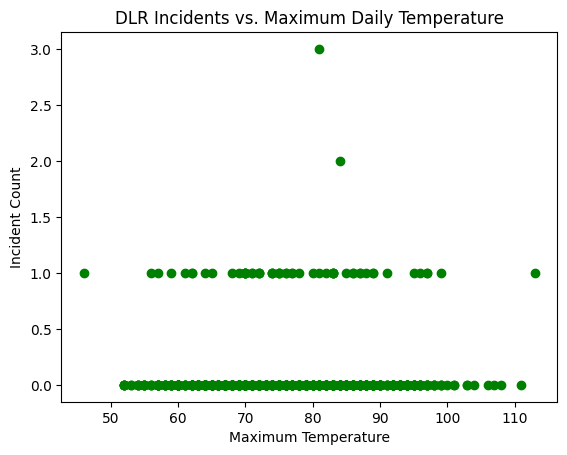

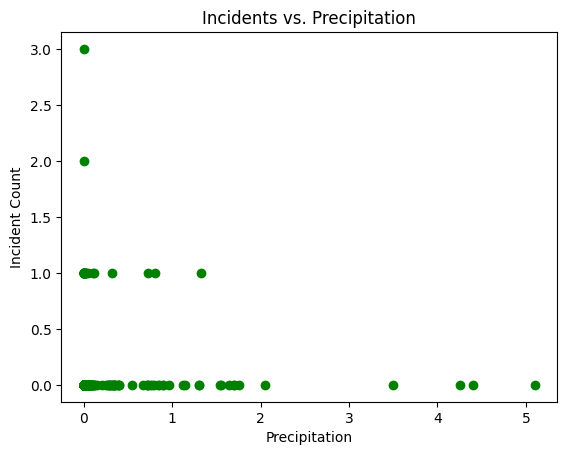

In [16]:
import matplotlib.pyplot as plt

# Scatterplot of Incidents vs. Max Temp (green dots)
plt.scatter(merged_df["Maximum"], merged_df["IncidentCount"], color="green")
plt.title("DLR Incidents vs. Maximum Daily Temperature")
plt.xlabel("Maximum Temperature")
plt.ylabel("Incident Count")
plt.show()

# Scatterplot of Incidents vs. Precipitation (green dots)
plt.scatter(merged_df["Precipitation"], merged_df["IncidentCount"], color="green")
plt.title("Incidents vs. Precipitation")
plt.xlabel("Precipitation")
plt.ylabel("Incident Count")
plt.show()



In [17]:
# Only keep rows where incident count >= 1
df_incidents_only = merged_df[merged_df["IncidentCount"] > 0]

corr_incidents_only = df_incidents_only[["IncidentCount", "Maximum"]].corr()
print(corr_incidents_only)


               IncidentCount   Maximum
IncidentCount       1.000000  0.069352
Maximum             0.069352  1.000000


In [18]:
merged_df["HasIncident"] = (merged_df["IncidentCount"] > 0).astype(int)
import statsmodels.formula.api as smf

model = smf.logit(formula="HasIncident ~ Maximum", data=merged_df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.273515
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            HasIncident   No. Observations:                  716
Model:                          Logit   Df Residuals:                      714
Method:                           MLE   Df Model:                            1
Date:                Mon, 17 Mar 2025   Pseudo R-squ.:                0.003159
Time:                        16:08:48   Log-Likelihood:                -195.84
converged:                       True   LL-Null:                       -196.46
Covariance Type:            nonrobust   LLR p-value:                    0.2653
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4802      0.925     -3.761      0.000      -5.294      -1.667
Maximum        0.0133      0.